In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tabulate import tabulate

# Problem1

In [2]:
def cubic_spline(x,y):
    n = len(x)
    
    h = np.zeros(n-1)
    for i in range(1,n):
        h[i-1] = x[i] - x[i-1]
        
    T = np.zeros((n-2, n-2))
    for i in range(n-2):
        T[i][i] = 2*(h[i] + h[i+1])
    for i in range(n-3):
        T[i+1][i] = h[i+1]
        T[i][i+1] = h[i+1]
        
    a = y
    ra = np.zeros(n-2)
    for i in range(n-2):
        ra[i] = 3/h[i+1]*(a[i+2]-a[i+1]) - 3/h[i]*(a[i+1]-a[i])
    
    c = np.zeros(n)
    c[1:n-1] = np.linalg.solve(T, ra)
    
    b = np.zeros(n-1)
    d = np.zeros(n-1)
    
    for i in range(n-1):
        b[i] = 1/h[i]*(a[i+1]-a[i]) - h[i]/3*(2*c[i]+c[i+1])
        d[i] = 1/(3*h[i])*(c[i+1]-c[i])
        
    a_res = a[:n-1]
    c_res = c[:n-1]
    
    return a_res, b, c_res, d

In [3]:
def cubic_spline_evaluation(a,b,c,d,x,x0):
    n = len(x)
    m = len(x0)
    res = []
    
    for j in range(m):
        for i in range(n-1):
            if x0[j] <= x[i+1]:
                S = a[i] + b[i]*(x0[j]-x[i]) + c[i]*(x0[j]-x[i])**2 + d[i]*(x0[j]-x[i])**3
                res.append(S)
                break
                
    return res

In [4]:
x = np.array([25, 19, 13, 9, 5, 2.2, 1, 3, 8, 13, 18, 25])
y = np.array([5, 7.5, 9.1, 9.4, 9.0, 7.5, 5, 2.1, 2, 3.5, 4.5, 5])
t = np.zeros(len(x))
t[0]=0
for i in range(1,len(x)):
    t[i] = t[i-1] + math.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2)

In [5]:
(a1,b1,c1,d1)= cubic_spline(t,x)
(a2,b2,c2,d2)= cubic_spline(t,y)

t0 = np.linspace(t[0], t[len(x)-1], 100)

xnew = cubic_spline_evaluation(a1,b1,c1,d1,t,t0)
ynew = cubic_spline_evaluation(a2,b2,c2,d2,t,t0)

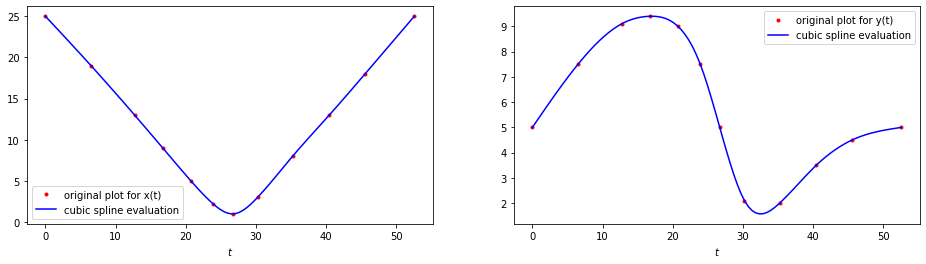

In [6]:
fig, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].plot(t, x, '.r', label="original plot for x(t)")
axs[0].plot(t0, xnew, '-b', label="cubic spline evaluation")
axs[0].set_xlabel('$t$')
axs[0].legend()

axs[1].plot(t, y, '.r', label="original plot for y(t)")
axs[1].plot(t0, ynew, '-b', label="cubic spline evaluation")
axs[1].set_xlabel('$t$')
axs[1].legend()

# Problem2

### For piecewise cubic Hermite interpolation, we decide to use $P(t_i) = y_iH_0(t_i) + y_{i+1}H_1(t_i) + y'_ih_0(t_i) + y'_{i+1}h_1(t_i)$, where $t_i = \frac{x-x_i}{x_{i+1} - x_i}$.

In [119]:
def Runge_func(x):
    f = 1/(1+x**2)
    f_ = -2*x/(1+x**2)**2
    return f,f_

In [172]:
def cubic_hermite_interpolation(x,X):
    y,y_ = Runge_func(x)
    n = len(X)
    P = []
    
    for i in range(n):
        idx = np.where(X[i] <= x)[0][0]
        if idx == 0:
            j = 0
        else:
            j = idx-1
            
        ti = (X[i]-x[j])/(x[j+1]-x[j])
                
        H0 = 2*ti**3-3*ti**2+1
        H1 = -2*ti**3+3*ti**2
        h0 = ti**3-2*ti**2+ti
        h1 = ti**3-ti**2
        
        Hj = H0*y[j] + H1*y[j+1] + h0*y_[j] + h1*y_[j+1]
        P.append(Hj)
        
    return P

In [192]:
def func_plot(ns):
    m = len(ns)
    X = np.linspace(-5,5,100)
    F, F_ = Runge_func(X)
    
    fig, axs = plt.subplots(1,m,figsize=(20,8))
    
    for i in range(m):
        x = np.linspace(-5,5,ns[i]+1)
        f, f_ = Runge_func(x)
        
        Y = cubic_hermite_interpolation(x,X)
        axs[i].plot(x, f,'.r', label="original points")
        axs[i].plot(X, F, 'g', label="true Runge function")
        axs[i].plot(X, Y, 'b', label="cubic hermite interpolation")
        axs[i].set_xlabel('$x$')
        axs[i].legend()

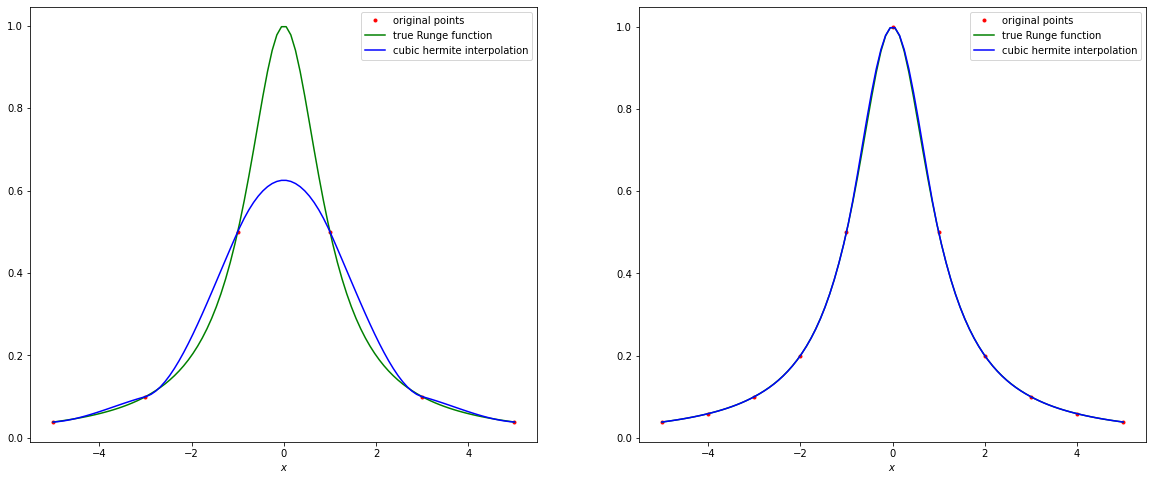

In [193]:
n = [5,10]
func_plot(n)

# Problem4

### (a)

#### $T(h) = \frac{h}{2}f(a) + h \sum_{i=1}^{n-1}f(a+ih) + \frac{h}{2}f(b)$

In [7]:
def trapezoidal_T(a,b,func,tol):
    rerr = math.inf
    h = b-a
    n = 1
    fa = func(a)
    fb = func(b)
    h_p = []
    T_p = []
    rerr_p = []
    
    while rerr >= tol:
        T = 0
        for i in range(1,n):
            T = T + func(a+i*h)
        T = h/2*(fa+fb) + h*T
        
        h = h/2
        n = 2*n
        T_ = 0
        for i in range(1,n):
            T_ = T_ + func(a+i*h)
        T_ = h/2*(fa+fb) + h*T_
        
        aerr = abs(T-T_)
        rerr = abs(T-T_)/abs(T_)
        
        h_p.append(h)
        T_p.append(T_)
        rerr_p.append(rerr)
    
    info = {'h/2': h_p, 'T(h/2)': T_p, '|T(h)-T(h/2)|/|T(h/2)|': rerr_p}
    print(tabulate(info, headers='keys'))
    return ("%10.8e"%T_), ("%10.8e"%aerr), ("%10.8e"%rerr), n+1

### (b)

#### $S(h)=\frac{h}{6}f(a) + \frac{2h}{3} \sum_{i=0}^{n-1}f(a+(i+\frac{1}{2}h)) + \frac{h}{3} \sum_{i=1}^{n-1}f(a+ih) + \frac{f}{6}f(b)$

In [8]:
def trapezoidal_S(a,b,func,tol):
    rerr = math.inf
    h = b-a
    n = 1
    fa = func(a)
    fb = func(b)
    h_p = []
    T_p = []
    rerr_p = []
    
    while rerr >= tol:
        T1 = 0
        T2 = 0
        for i in range(n):
            T1 = T1 + func(a+(i+0.5)*h)
        for i in range(1,n):
            T2 = T2 + func(a+i*h)
            
        T = h/6*(fa+fb) + 2*h/3*T1 + h/3*T2
        
        h = h/2
        n = 2*n
        T1_ = 0
        T2_ = 0
        for i in range(n):
            T1_ = T1_ + func(a+(i+0.5)*h)
        for i in range(1,n):
            T2_ = T2_ + func(a+i*h)
        T_ = h/2*(fa+fb) + 2*h/3*T1_ + h/3*T2_
        
        aerr = abs(T-T_)
        rerr = abs(T-T_)/abs(T_)
        
        h_p.append(h)
        T_p.append(T_)
        rerr_p.append(rerr)
    
    info = {'h/2': h_p, 'T(h/2)': T_p, '|T(h)-T(h/2)|/|T(h/2)|': rerr_p}
    print(tabulate(info, headers='keys'))
    return ("%10.8e"%T_), ("%10.8e"%aerr), ("%10.8e"%rerr), n+1

### (c)

In [9]:
def func1(x):
    return x/(1+x**2)

def func2(x):
    return 1/(1-x)

def func3(x):
    return (1/math.sqrt(1-0.5*(math.sin(x))**2))

def func4(x):
    return (1/math.sqrt(1-0.8*(math.sin(x))**2))

def func5(x):
    return (1/math.sqrt(1-0.95*(math.sin(x))**2))

In [10]:
def print_res1(a,b,func,tv):
    print("Composite trapezoidal rule")
    print("Approximate value of the integral = ", "%10.7e"% float(tav))
    print("Absolute error                    = ", "%10.7e"% (abs(float(tav)-tv)))
    print("Relative error                    = ", "%10.7e"% (abs(float(tav)-tv)/abs(tv)))
    print("Number of f evaluations required  =   ", tn)
    print()
    print("Composite Simpson rule")
    print("Approximate value of the integral = ", "%10.7e"% float(sav))
    print("Absolute error                    = ", "%10.7e"% (abs(float(sav)-tv)))
    print("Relative error                    = ", "%10.7e"% (abs(float(sav)-tv)/abs(tv)))
    print("Number of f evaluations required  =   ", sn)

In [32]:
def print_res2(a,b,func):
    print("Composite trapezoidal rule")
    print("Approximate value of the integral = ", "%10.7e"% float(tav))
    print("Number of f evaluations required  =   ", tn)
    print()
    print("Composite Simpson rule")
    print("Approximate value of the integral = ", "%10.7e"% float(sav))
    print("Number of f evaluations required  =   ", sn)

### $\int_0^3{\frac{x}{1+x^2}}dx = \frac{1}{2}log(10)$

In [11]:
(tav, tae, tre, tn) = trapezoidal_T(0,3,func1,1.e-6)

       h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
----------  --------  ------------------------
1.5         0.917308               0.509434
0.75        1.097                  0.163807
0.375       1.13846                0.0364126
0.1875      1.14812                0.00841331
0.09375     1.1505                 0.00207114
0.046875    1.15109                0.000515914
0.0234375   1.15124                0.000128863
0.0117188   1.15128                3.22087e-05
0.00585938  1.15129                8.05172e-06
0.00292969  1.15129                2.0129e-06
0.00146484  1.15129                5.03224e-07


In [12]:
(sav, sae, sre, sn) = trapezoidal_S(0,3,func1,1.e-6)

        h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
-----------  --------  ------------------------
1.5           1.3069                0.178916
0.75          1.22728               0.0573411
0.375         1.18884               0.0307537
0.1875        1.17005               0.0159885
0.09375       1.16067               0.00807513
0.046875      1.15598               0.00405487
0.0234375     1.15364               0.00203161
0.0117188     1.15246               0.00101684
0.00585938    1.15188               0.00050868
0.00292969    1.15159               0.000254405
0.00146484    1.15144               0.000127219
0.000732422   1.15137               6.36133e-05
0.000366211   1.15133               3.18077e-05
0.000183105   1.15131               1.59041e-05
9.15527e-05   1.1513                7.95211e-06
4.57764e-05   1.1513                3.97607e-06
2.28882e-05   1.15129               1.98804e-06
1.14441e-05   1.15129               9.9402e-07


In [13]:
tv = 0.5*math.log(10)
print("f(x)=x/(1+x^2), [a,b] = [0,3]")
print_res1(0,3,func1,tv)

f(x)=x/(1+x^2), [a,b] = [0,3]
Composite trapezoidal rule
Approximate value of the integral =  1.1512924e+00
Absolute error                    =  1.9649702e-07
Relative error                    =  1.7067515e-07
Number of f evaluations required  =    2049

Composite Simpson rule
Approximate value of the integral =  1.1512937e+00
Absolute error                    =  1.1435030e-06
Relative error                    =  9.9323407e-07
Number of f evaluations required  =    262145


### $\int_0^{0.95}{\frac{1}{1-x}}dx = log(20)$

In [14]:
(tav, tae, tre, tn) = trapezoidal_T(0,0.95,func2,1.e-6)

        h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
-----------  --------  ------------------------
0.475         5.89226               0.692898
0.2375        4.08369               0.442876
0.11875       3.35708               0.216444
0.059375      3.10177               0.082309
0.0296875     3.02413               0.025673
0.0148437     3.003                 0.00703872
0.00742187    2.99756               0.00181362
0.00371094    2.99619               0.000457218
0.00185547    2.99585               0.000114552
0.000927734   2.99576               2.86535e-05
0.000463867   2.99574               7.16436e-06
0.000231934   2.99573               1.79115e-06
0.000115967   2.99573               4.47792e-07


In [15]:
(sav, sae, sre, sn) = trapezoidal_S(0,0.95,func2,1.e-6)

        h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
-----------  --------  ------------------------
0.475         6.80584               0.334197
0.2375        4.77737               0.271391
0.11875       3.84792               0.190506
0.059375      3.41388               0.116351
0.0296875     3.20376               0.0641461
0.0148437     3.09965               0.0334565
0.00742187    3.04769               0.017042
0.00371094    3.02171               0.00859634
0.00185547    3.00872               0.00431686
0.000927734   3.00223               0.00216311
0.000463867   2.99898               0.00108273
0.000231934   2.99736               0.000541656
0.000115967   2.99654               0.000270901
5.79834e-05   2.99614               0.000135469
2.89917e-05   2.99594               6.77391e-05
1.44958e-05   2.99583               3.38707e-05
7.24792e-06   2.99578               1.69356e-05
3.62396e-06   2.99576               8.46789e-06
1.81198e-06   2.99574               4.23396e-06
9.05991e-07   2

In [16]:
tv = math.log(20)
print("f(x)=1/(1-x), [a,b] = [0,0.95]")
print_res1(0,0.95,func2,tv)

f(x)=1/(1-x), [a,b] = [0,0.95]
Composite trapezoidal rule
Approximate value of the integral =  2.9957327e+00
Absolute error                    =  4.4644601e-07
Relative error                    =  1.4902734e-07
Number of f evaluations required  =    8193

Composite Simpson rule
Approximate value of the integral =  2.9957339e+00
Absolute error                    =  1.5864460e-06
Relative error                    =  5.2956869e-07
Number of f evaluations required  =    4194305


### $\int_0^{\pi/2}{\frac{1}{\sqrt{1-msin^2(x)}}}dx, m=0.5$

In [33]:
(tav, tae, tre, tn) = trapezoidal_T(0,math.pi/2,func3,1.e-6)

     h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
--------  --------  ------------------------
0.785398   1.85496               0.022189
0.392699   1.85408               0.000476735
0.19635    1.85407               2.96895e-07


In [34]:
(sav, sae, sre, sn) = trapezoidal_S(0,math.pi/2,func3,1.e-6)

        h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
-----------  --------  ------------------------
0.785398      2.48582               0.259303
0.392699      2.17009               0.14576
0.19635       2.01208               0.0785305
0.0981748     1.93308               0.04087
0.0490874     1.89358               0.0208613
0.0245437     1.87383               0.0105406
0.0122718     1.86395               0.00529822
0.00613592    1.85901               0.00265615
0.00306796    1.85654               0.00132984
0.00153398    1.85531               0.000665362
0.00076699    1.85469               0.000332792
0.000383495   1.85438               0.000166424
0.000191748   1.85423               8.32187e-05
9.58738e-05   1.85415               4.16111e-05
4.79369e-05   1.85411               2.0806e-05
2.39684e-05   1.85409               1.04031e-05
1.19842e-05   1.85408               5.20158e-06
5.99211e-06   1.85408               2.60079e-06
2.99606e-06   1.85408               1.3004e-06
1.49803e-06   

In [36]:
print("f(x)=1/sqrt(1-msin^2x), [a,b] = [0,pi/2]")
print_res2(0,math.pi/2,func3)

f(x)=1/sqrt(1-msin^2x), [a,b] = [0,pi/2]
Composite trapezoidal rule
Approximate value of the integral =  1.8540747e+00
Number of f evaluations required  =    9

Composite Simpson rule
Approximate value of the integral =  1.8540759e+00
Number of f evaluations required  =    1048577


### $\int_0^{\pi/2}{\frac{1}{\sqrt{1-msin^2(x)}}}dx, m=0.8$

In [37]:
(tav, tae, tre, tn) = trapezoidal_T(0,math.pi/2,func4,1.e-6)

      h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
---------  --------  ------------------------
0.785398    2.28475               0.112422
0.392699    2.25762               0.0120144
0.19635     2.25721               0.000184328
0.0981748   2.25721               5.96498e-08


In [38]:
(sav, sae, sre, sn) = trapezoidal_S(0,math.pi/2,func4,1.e-6)

        h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
-----------  --------  ------------------------
0.785398      3.09578               0.289637
0.392699      2.68067               0.161186
0.19635       2.46901               0.0858397
0.0981748     2.36311               0.044814
0.0490874     2.31016               0.0229206
0.0245437     2.28368               0.0115931
0.0122718     2.27044               0.00583036
0.00613592    2.26382               0.00292371
0.00306796    2.26051               0.00146399
0.00153398    2.25886               0.000732533
0.00076699    2.25803               0.000366401
0.000383495   2.25762               0.000183234
0.000191748   2.25741               9.16253e-05
9.58738e-05   2.25731               4.58148e-05
4.79369e-05   2.25726               2.29079e-05
2.39684e-05   2.25723               1.14541e-05
1.19842e-05   2.25722               5.72707e-06
5.99211e-06   2.25721               2.86355e-06
2.99606e-06   2.25721               1.43177e-06
1.49803e-0

In [39]:
print("f(x)=1/sqrt(1-msin^2x), [a,b] = [0,pi/2]")
print_res2(0,math.pi/2,func4)

f(x)=1/sqrt(1-msin^2x), [a,b] = [0,pi/2]
Composite trapezoidal rule
Approximate value of the integral =  2.2572053e+00
Number of f evaluations required  =    17

Composite Simpson rule
Approximate value of the integral =  2.2572069e+00
Number of f evaluations required  =    1048577


### $\int_0^{\pi/2}{\frac{1}{\sqrt{1-msin^2(x)}}}dx, m=0.95$

In [40]:
(tav, tae, tre, tn) = trapezoidal_T(0,math.pi/2,func5,1.e-6)

      h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
---------  --------  ------------------------
0.785398    3.23286               0.329415
0.392699    2.94267               0.0986139
0.19635     2.90897               0.0115828
0.0981748   2.90834               0.000218584
0.0490874   2.90834               1.07601e-07


In [41]:
(sav, sae, sre, sn) = trapezoidal_S(0,math.pi/2,func5,1.e-6)

        h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
-----------  --------  ------------------------
0.785398      4.27854               0.327371
0.392699      3.61404               0.212533
0.19635       3.26628               0.11283
0.0981748     3.08741               0.0580702
0.0490874     2.99787               0.0298671
0.0245437     2.95311               0.0151599
0.0122718     2.93072               0.00763785
0.00613592    2.91953               0.00383356
0.00306796    2.91393               0.00192046
0.00153398    2.91114               0.000961154
0.00076699    2.90974               0.000480808
0.000383495   2.90904               0.000240462
0.000191748   2.90869               0.000120245
9.58738e-05   2.90851               6.01263e-05
4.79369e-05   2.90842               3.00641e-05
2.39684e-05   2.90838               1.50323e-05
1.19842e-05   2.90836               7.51619e-06
5.99211e-06   2.90835               3.75811e-06
2.99606e-06   2.90834               1.87906e-06
1.49803e-06

In [42]:
print("f(x)=1/sqrt(1-msin^2x), [a,b] = [0,pi/2]")
print_res2(0,math.pi/2,func5)

f(x)=1/sqrt(1-msin^2x), [a,b] = [0,pi/2]
Composite trapezoidal rule
Approximate value of the integral =  2.9083373e+00
Number of f evaluations required  =    33

Composite Simpson rule
Approximate value of the integral =  2.9083400e+00
Number of f evaluations required  =    1048577


# Problem5

### ii

In [26]:
def appro1(func):
    for n in (5,10,15):
        x = np.zeros(n+1)
        for i in range(n+1):
            x[i] = -5 + i*10/n
        
        X = np.ones((n+1,n+1))
        for i in range(1,n+1):
            X[i:] = x**i
        
        a, b = -5, 5
        d = np.zeros(n+1)
        for i in range(n+1):
            d[i] = 1/(i+1)*(b**(i+1) - a**(i+1))
        
        w = np.linalg.solve(X, d)
        
        f = func(x)
        appro = np.inner(w,f)
        
        print("When n = ", n)
        print("Nodes are: ")
        print(x)
        print("The corresponding weights is: ")
        print(w)
        print("The computed approximation of the integral is: ", appro)
        print()

In [27]:
def func(x):
    return 1/(1+x**2)

In [28]:
appro(func)

When n =  5
Nodes are: 
[-5. -3. -1.  1.  3.  5.]
The corresponding weights is: 
[0.65972222 2.60416667 1.73611111 1.73611111 2.60416667 0.65972222]
The computed approximation of the integral is:  2.307692307692308

When n =  10
Nodes are: 
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
The corresponding weights is: 
[ 0.26834148  1.77535941 -0.81043571  4.54946288 -4.35155123  7.1376463
 -4.35155123  4.54946288 -0.81043571  1.77535941  0.26834148]
The computed approximation of the integral is:  4.673300555675389

When n =  15
Nodes are: 
[-5.         -4.33333333 -3.66666667 -3.         -2.33333333 -1.66666667
 -1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
  3.          3.66666667  4.33333333  5.        ]
The corresponding weights is: 
[ 0.170873    1.28507379 -1.12722905  5.07042708 -7.56293115 11.9136035
 -9.68005213  4.93023502  4.93023483 -9.68005203 11.91360346 -7.56293114
  5.07042708 -1.12722905  1.28507379  0.170873  ]
The computed approximation of the 

### iii

### For better quadrature nodes, we choose chebyshev point.

In [48]:
def Chebyshev(a,b,n):
    x = np.zeros(n)
    for i in range(n):
        x[i] = (a+b)/2 + (b-a)/2*math.cos((2*(i+1)-1)*math.pi/(2*n))
    return x

In [52]:
def appro2(a,b,func):
    for n in (5,10,15):
        x = Chebyshev(a,b,n+1)
        
        X = np.ones((n+1,n+1))
        for i in range(1,n+1):
            X[i:] = x**i
        
        a, b = -5, 5
        d = np.zeros(n+1)
        for i in range(n+1):
            d[i] = 1/(i+1)*(b**(i+1) - a**(i+1))
        
        w = np.linalg.solve(X, d)
        
        f = func(x)
        appro = np.inner(w,f)
        
        print("When n = ", n)
        print("Nodes are: ")
        print(x)
        print("The corresponding weights is: ")
        print(w)
        print("The computed approximation of the integral is: ", appro)
        print()

In [53]:
appro2(-5,5,func)

When n =  5
Nodes are: 
[ 4.82962913  3.53553391  1.29409523 -1.29409523 -3.53553391 -4.82962913]
The corresponding weights is: 
[0.59330511 1.88888889 2.517806   2.517806   1.88888889 0.59330511]
The computed approximation of the integral is:  2.2113115356791333

When n =  10
Nodes are: 
[ 4.94910721e+00  4.54815998e+00  3.77874787e+00  2.70320409e+00
  1.40866278e+00  1.41638472e-15 -1.40866278e+00 -2.70320409e+00
 -3.77874787e+00 -4.54815998e+00 -4.94910721e+00]
The corresponding weights is: 
[0.17698858 0.60847767 0.92441624 1.20994808 1.36247298 1.43539289
 1.36247298 1.20994808 0.92441624 0.60847767 0.17698858]
The computed approximation of the integral is:  2.8307823662953737

When n =  15
Nodes are: 
[ 4.97592363  4.78470168  4.40960632  3.86505227  3.17196642  2.35698368
  1.45142339  0.4900857  -0.4900857  -1.45142339 -2.35698368 -3.17196642
 -3.86505227 -4.40960632 -4.78470168 -4.97592363]
The corresponding weights is: 
[0.08401378 0.29168232 0.45859157 0.62564809 0.75696231

### iv

In [29]:
(tav, tae, tre, tn) = trapezoidal_T(-5,5,func,1.e-4)

    h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
-------  --------  ------------------------
5         5.19231               0.925926
2.5       3.28581               0.580222
1.25      2.78449               0.18004
0.625     2.74611               0.0139753
0.3125    2.74656               0.000163595
0.15625   2.74674               6.56813e-05


In [30]:
(sav, sae, sre, sn) = trapezoidal_S(-5,5,func,1.e-4)

       h/2    T(h/2)    |T(h)-T(h/2)|/|T(h/2)|
----------  --------  ------------------------
5            2.77851               1.44551
2.5          2.68149               0.0116264
1.25         2.76537               0.0535145
0.625        2.76274               0.0106479
0.3125       2.75481               0.00294161
0.15625      2.75081               0.00145646
0.078125     2.7488                0.000728756
0.0390625    2.7478                0.00036451
0.0195312    2.7473                0.000182288
0.00976562   2.74705               9.11525e-05


In [31]:
print("f(x)=x/(1+x^2), [a,b] = [-5,5]")
print("Composite trapezoidal rule")
print("Approximate value of the integral = ", "%10.7e"% float(tav))
print("Number of f evaluations required  =   ", tn)
print()
print("Composite Simpson rule")
print("Approximate value of the integral = ", "%10.7e"% float(sav))
print("Number of f evaluations required  =   ", sn)

f(x)=x/(1+x^2), [a,b] = [-5,5]
Composite trapezoidal rule
Approximate value of the integral =  2.7467414e+00
Number of f evaluations required  =    65

Composite Simpson rule
Approximate value of the integral =  2.7470519e+00
Number of f evaluations required  =    1025
